In [10]:
import torch, torchvision
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## We're going to fully run the workflow for KNN here as a demo. It will contain Cross-Validation, Testing, and all images used. 

# adult dataset

In [3]:
## import data here

data = fetch_ucirepo(name = "adult") 
# load data
df = pd.read_csv(data.metadata['data_url'])

df.replace('?', np.nan, inplace=True)

X = df.drop(["income"], axis=1)
y = df["income"]


## there are technically 4 different y's. <=50k, >50k, <=50k., >50k.
## this is the stupidest possible way to fix it. But it works

y = y.replace("<=50K", 0)
y = y.replace("<=50K.", 0)
y = y.replace(">50K.", 1)
y = y.replace(">50K", 1)

# drop useless columns
X.drop(["fnlwgt","education-num"], axis=1, inplace=True)

## categorical variables need to be dealt with
## convert from object to category
# this is to stop the warnings that I'm using a slice of a dataframe when setting the cat values
pd.options.mode.chained_assignment = None  # default='warn'
for i in ["workclass","education","marital-status","occupation","relationship","race","sex","native-country"]:
    X[i] = X[i].astype('category')
    X[i] = X[i].cat.codes
# scale non-categorical variables

scaler = StandardScaler()
for i in ["age","capital-gain","capital-loss","hours-per-week"]:
    X[i] = scaler.fit_transform(X[[i]])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [4]:
## we're going to quickly tune our PCA dimensions based on the expected explained variance
d_list = []
pca_list = range(1, min(X_train.shape[1],10))
for d in pca_list:
    pca = PCA(n_components=d, random_state=42)
    pca.fit(X_train)
    d_list.append(np.sum(pca.explained_variance_ratio_))
    print("Dimension reduced to: ", d)
    print("Cumulative Explained Variance: ", np.sum(pca.explained_variance_ratio_))


## the thought is to explain about 90% of the variance in the data
## not really any proof behind this, just think 90% seems to make the most sense. 

Dimension reduced to:  1
Cumulative Explained Variance:  0.5677544564331235
Dimension reduced to:  2
Cumulative Explained Variance:  0.7430507433897917
Dimension reduced to:  3
Cumulative Explained Variance:  0.887411444445305
Dimension reduced to:  4
Cumulative Explained Variance:  0.9191436315031453
Dimension reduced to:  5
Cumulative Explained Variance:  0.9382333496164318
Dimension reduced to:  6
Cumulative Explained Variance:  0.9567678537770911
Dimension reduced to:  7
Cumulative Explained Variance:  0.9666288856925175
Dimension reduced to:  8
Cumulative Explained Variance:  0.9759311367917182
Dimension reduced to:  9
Cumulative Explained Variance:  0.9847368310594107


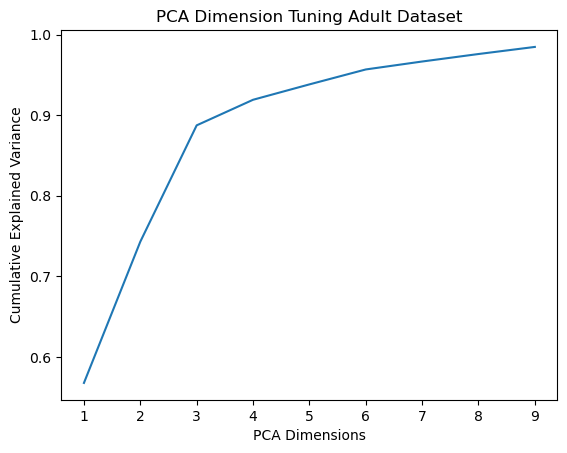

In [15]:
plt.plot(pca_list, d_list)
plt.xlabel("PCA Dimensions")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Dimension Tuning Adult Dataset")
plt.savefig("PCA_Dimensions_adult.png")

In [6]:
## 10 fold cv versus using 5-repeated ?
std_error = []
neighbor_accuracy = []
train_accuracy = []
cv = KFold(n_splits=10, random_state=42, shuffle=True)
neighbor_list = range(1,20)
for j in  neighbor_list:
    print(j)
    pca = PCA(n_components=5, random_state=42)
    knn = KNeighborsClassifier(n_neighbors=j, n_jobs=-1) # more cores go BRRRRRT
    accounting = []
    train_accounting =[]
    for train_index, val_index in cv.split(X_train):
        expl_train, expl_val = X_train.iloc[train_index], X_train.iloc[val_index]
        response_train, response_val = y_train.iloc[train_index], y_train.iloc[val_index]

        ## pca
        ## fit the transform on the training data
        expl_pca_train = pca.fit_transform(expl_train)
        ## transform the validation data based on the train fit.
        expl_pca_val = pca.transform(expl_val)

        ## fit
        ## ravel is needed to stop an error message. Truthfully I cannot remember why I needed it
        knn.fit((expl_pca_train), response_train.values.ravel())

        ## accuracy calculation
        ## train accuracy
        predict = knn.predict(expl_pca_train)
        score_train = np.mean(predict == response_train.values.ravel())
        train_accounting.append(score_train)
        predict = knn.predict(expl_pca_val)
        score = np.mean(predict == response_val.values.ravel())
        accounting.append(score)
    std_error.append(np.std(accounting))
    neighbor_accuracy.append((np.mean(accounting)))
    train_accuracy.append(np.mean(train_accounting))
    print("Iteration Accuracy: ", np.mean(accounting))

1
Iteration Accuracy:  0.7880451639217514
2
Iteration Accuracy:  0.805891903228385
3
Iteration Accuracy:  0.8101699128305458
4
Iteration Accuracy:  0.8176877926907341
5
Iteration Accuracy:  0.819979623234331
6
Iteration Accuracy:  0.8212628122812641
7
Iteration Accuracy:  0.82413505662765
8
Iteration Accuracy:  0.8254798746056682
9
Iteration Accuracy:  0.8251130610753913
10
Iteration Accuracy:  0.8259075326988169
11
Iteration Accuracy:  0.8261824724331923
12
Iteration Accuracy:  0.826824225697845
13
Iteration Accuracy:  0.8273131485511225
14
Iteration Accuracy:  0.8272522012733659
15
Iteration Accuracy:  0.8280772912702806
16
Iteration Accuracy:  0.8271910859167061
17
Iteration Accuracy:  0.825938095046005
18
Iteration Accuracy:  0.8267633624595397
19
Iteration Accuracy:  0.8267632690823714


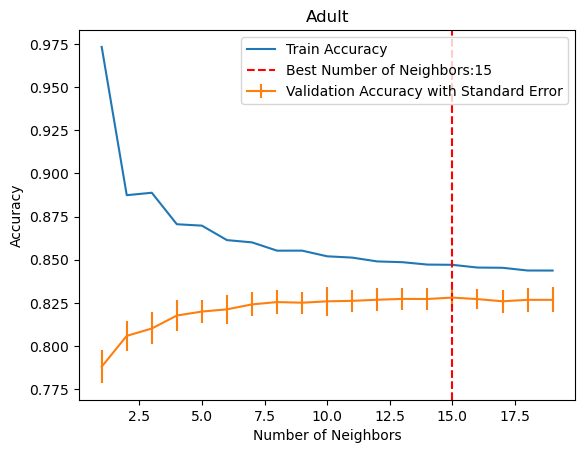

In [8]:
plt.plot(neighbor_list, train_accuracy, label = "Train Accuracy")
plt.errorbar(neighbor_list, neighbor_accuracy, yerr=std_error, label = "Validation Accuracy with Standard Error")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
# plot a dashed line at the best number of neighbors
plt.axvline(np.argmax(neighbor_accuracy)+1, color = "r", linestyle = "--",
             label = "Best Number of Neighbors:" + str(np.argmax(neighbor_accuracy)+1))
plt.title("Adult")
plt.legend()
plt.show()

Train Accuracy:  0.8469013568023469
Test Accuracy:  0.8251023700210944


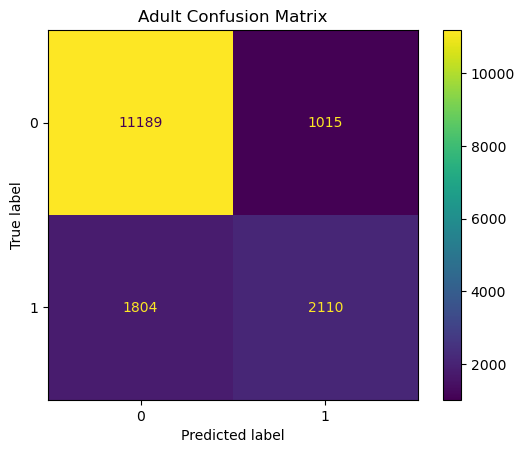

In [16]:
## now we get the actual train/test accuracy
pca = PCA(n_components=5, random_state=42)
knn = KNeighborsClassifier(n_neighbors=15, n_jobs=-1)

## transform the training and test data
expl_pca_train = pca.fit_transform(X_train)
expl_pca_test = pca.transform(X_test)

## fit the model
knn.fit(expl_pca_train, y_train.values.ravel())

## predict
predict = knn.predict(expl_pca_test)
predict_train = knn.predict(expl_pca_train)

## accuracy
test_score = np.mean(predict == y_test.values.ravel())
train_score = np.mean(predict_train == y_train.values.ravel())

print("Train Accuracy: ", train_score)
print("Test Accuracy: ", test_score)

## confusion matrix
cm = confusion_matrix(y_test, predict, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()
plt.title("Adult Confusion Matrix")
plt.savefig("adult_confusion_matrix.png")



## breast cancer wisconsin

In [18]:
## load data

data = fetch_ucirepo(name = "Breast Cancer Wisconsin") 
# load data
df = pd.read_csv(data.metadata['data_url'])
df.dropna(inplace=True)
## Y's are the class
## X's are really anything else, minus sample code number
X = df.drop(["Class"], axis=1)
X.drop(["Sample_code_number"], axis=1, inplace=True)
y = df["Class"]

## reclass y into 0,1 instead of 2,4
y = y.replace(2, 0)
y = y.replace(4, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [19]:
## we're going to quickly tune our PCA dimensions based on the expected explained variance
d_list = []
pca_list = range(1, min(X_train.shape[1],10))
for d in pca_list:
    pca = PCA(n_components=d, random_state=42)
    pca.fit(X_train)
    d_list.append(np.sum(pca.explained_variance_ratio_))
    print("Dimension reduced to: ", d)
    print("Cumulative Explained Variance: ", np.sum(pca.explained_variance_ratio_))

Dimension reduced to:  1
Cumulative Explained Variance:  0.6840136797929514
Dimension reduced to:  2
Cumulative Explained Variance:  0.7582816621963482
Dimension reduced to:  3
Cumulative Explained Variance:  0.8211296045836542
Dimension reduced to:  4
Cumulative Explained Variance:  0.8703723933261951
Dimension reduced to:  5
Cumulative Explained Variance:  0.9114357567163318
Dimension reduced to:  6
Cumulative Explained Variance:  0.9440825638959918
Dimension reduced to:  7
Cumulative Explained Variance:  0.9677200434531991
Dimension reduced to:  8
Cumulative Explained Variance:  0.9880942724203161


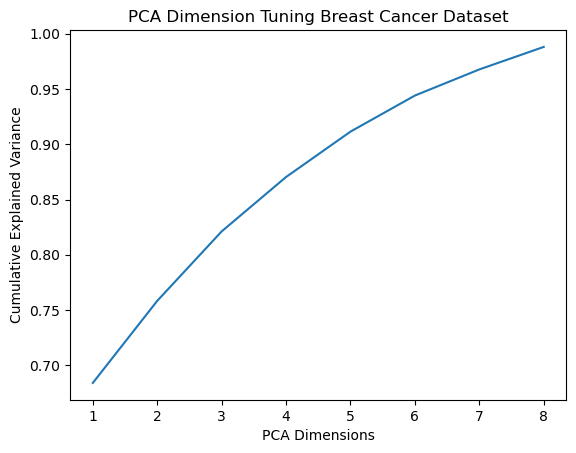

In [20]:
plt.plot(pca_list, d_list)
plt.xlabel("PCA Dimensions")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Dimension Tuning Breast Cancer Dataset")
plt.savefig("PCA_Dimensions_breast_cancer.png")

In [21]:
## 10 fold cv versus using 5-repeated ?
std_error = []
neighbor_accuracy = []
train_accuracy = []
cv = KFold(n_splits=10, random_state=42, shuffle=True)
neighbor_list = range(1,40)
for j in  neighbor_list:
    print(j)
    pca = PCA(n_components=6, random_state=42)
    knn = KNeighborsClassifier(n_neighbors=j, n_jobs=-1) # more cores go BRRRRRT
    accounting = []
    for train_index, val_index in cv.split(X_train):
        expl_train, expl_val = X_train.iloc[train_index], X_train.iloc[val_index]
        response_train, response_val = y_train.iloc[train_index], y_train.iloc[val_index]

        ## pca
        ## fit the transform on the training data
        expl_pca_train = pca.fit_transform(expl_train)
        ## transform the validation data based on the train fit.
        expl_pca_val = pca.transform(expl_val)

        ## fit
        ## ravel is needed to stop an error message. Truthfully I cannot remember why I needed it
        knn.fit((expl_pca_train), response_train.values.ravel())

        ## train accuracy
        predict = knn.predict(expl_pca_train)
        score_train = np.mean(predict == response_train.values.ravel())
        train_accounting.append(score_train)
        predict = knn.predict(expl_pca_val)
        score = np.mean(predict == response_val.values.ravel())
        accounting.append(score)
    std_error.append(np.std(accounting))
    neighbor_accuracy.append((np.mean(accounting)))
    train_accuracy.append(np.mean(train_accounting))
    print("Iteration Accuracy: ", np.mean(accounting))

1
Iteration Accuracy:  0.9585024154589371
2
Iteration Accuracy:  0.9453623188405798
3
Iteration Accuracy:  0.9651690821256039
4
Iteration Accuracy:  0.9629468599033817
5
Iteration Accuracy:  0.9673429951690821
6
Iteration Accuracy:  0.9695169082125604
7
Iteration Accuracy:  0.9694685990338165
8
Iteration Accuracy:  0.9651690821256039
9
Iteration Accuracy:  0.9651690821256039
10
Iteration Accuracy:  0.9629951690821257
11
Iteration Accuracy:  0.9651690821256039
12
Iteration Accuracy:  0.9673429951690821
13
Iteration Accuracy:  0.9628985507246377
14
Iteration Accuracy:  0.9673429951690821
15
Iteration Accuracy:  0.9695169082125604
16
Iteration Accuracy:  0.9673429951690821
17
Iteration Accuracy:  0.9717391304347827
18
Iteration Accuracy:  0.9695652173913043
19
Iteration Accuracy:  0.9717391304347827
20
Iteration Accuracy:  0.9717391304347827
21
Iteration Accuracy:  0.9717391304347827
22
Iteration Accuracy:  0.9695652173913043
23
Iteration Accuracy:  0.9695652173913043
24
Iteration Accurac

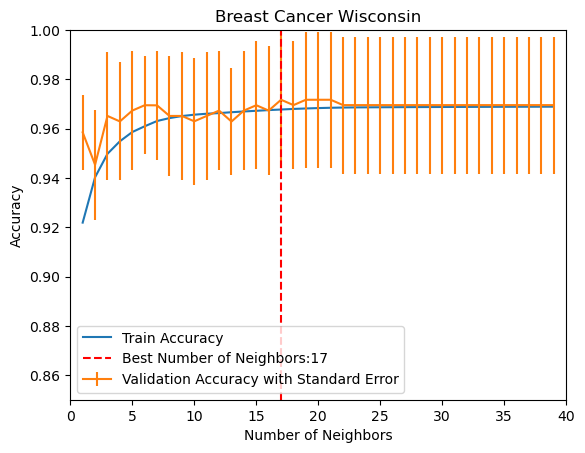

In [22]:
plt.plot(neighbor_list, train_accuracy, label = "Train Accuracy")
plt.errorbar(neighbor_list, neighbor_accuracy, yerr=std_error, label = "Validation Accuracy with Standard Error")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
# plot a dashed line at the best number of neighbors
plt.axvline(np.argmax(neighbor_accuracy)+1, color = "r", linestyle = "--",
             label = "Best Number of Neighbors:" + str(np.argmax(neighbor_accuracy)+1))
## this is too zoomed in
plt.xlim(0,40)
plt.ylim(0.85,1)
plt.title("Breast Cancer Wisconsin")
plt.legend()
plt.show()

Train Accuracy:  0.9715536105032823
Test Accuracy:  0.9557522123893806


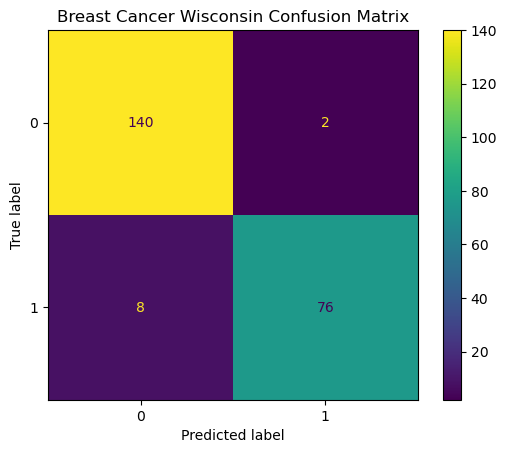

In [23]:
## now we get the actual train/test accuracy
pca = PCA(n_components=5, random_state=42)
knn = KNeighborsClassifier(n_neighbors=15, n_jobs=-1)

## transform the training and test data
expl_pca_train = pca.fit_transform(X_train)
expl_pca_test = pca.transform(X_test)

## fit the model
knn.fit(expl_pca_train, y_train.values.ravel())

## predict
predict = knn.predict(expl_pca_test)
predict_train = knn.predict(expl_pca_train)

## accuracy
test_score = np.mean(predict == y_test.values.ravel())
train_score = np.mean(predict_train == y_train.values.ravel())

print("Train Accuracy: ", train_score)
print("Test Accuracy: ", test_score)

## confusion matrix
cm = confusion_matrix(y_test, predict, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()
plt.title("Breast Cancer Wisconsin Confusion Matrix")
plt.savefig("breast_cancer_confusion_matrix.png")

# FMNIST

In [24]:
train_set = torchvision.datasets.FashionMNIST("/Users/johnleland/Downloads/", download=True)
test_set = torchvision.datasets.FashionMNIST("/Users/johnleland/Downloads/",download=True,train=False)
X_train = train_set.data.numpy()
labels_train = train_set.targets.numpy()
X_test = test_set.data.numpy()
labels_test = test_set.targets.numpy()
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
X_train = X_train/255.0
X_test = X_test/255.0
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(labels_train)
y_test = pd.DataFrame(labels_test)

In [25]:
## i refuse to go above 50 dimensions for this.
## we're going to quickly tune our PCA dimensions based on the expected explained variance
d_list = []
pca_list = range(1, min(X_train.shape[1],50)) ## fmnist ruins my whole flow
for d in pca_list:
    pca = PCA(n_components=d, random_state=42)
    pca.fit(X_train)
    d_list.append(np.sum(pca.explained_variance_ratio_))
    print("Dimension reduced to: ", d)
    print("Cumulative Explained Variance: ", np.sum(pca.explained_variance_ratio_))


Dimension reduced to:  1
Cumulative Explained Variance:  0.2903922792136596
Dimension reduced to:  2
Cumulative Explained Variance:  0.4679453789952809
Dimension reduced to:  3
Cumulative Explained Variance:  0.5281375988269706
Dimension reduced to:  4
Cumulative Explained Variance:  0.5777118788639692
Dimension reduced to:  5
Cumulative Explained Variance:  0.6161884303430272
Dimension reduced to:  6
Cumulative Explained Variance:  0.6507961235228436
Dimension reduced to:  7
Cumulative Explained Variance:  0.6742130287464206
Dimension reduced to:  8
Cumulative Explained Variance:  0.6932671650189758
Dimension reduced to:  9
Cumulative Explained Variance:  0.7067655992085998
Dimension reduced to:  10
Cumulative Explained Variance:  0.7199082700796513
Dimension reduced to:  11
Cumulative Explained Variance:  0.7298369943934075
Dimension reduced to:  12
Cumulative Explained Variance:  0.7389695115710994
Dimension reduced to:  13
Cumulative Explained Variance:  0.7466274709923566
Dimensio

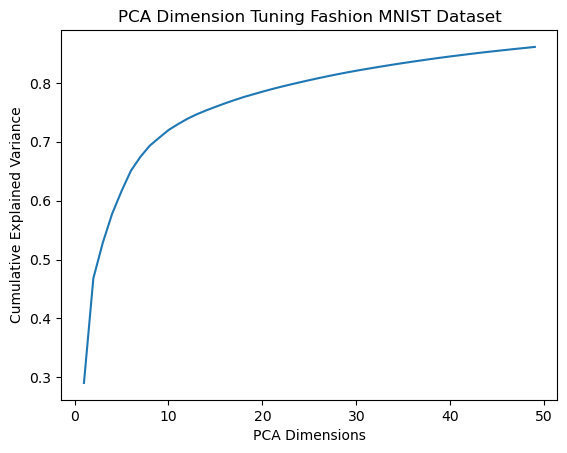

In [26]:
plt.plot(pca_list, d_list)
plt.xlabel("PCA Dimensions")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Dimension Tuning Fashion MNIST Dataset")
plt.savefig("PCA_Dimensions_fashion_mnist.png")

In [53]:
## 10 fold cv versus using 5-repeated ?
std_error = []
neighbor_accuracy = []
train_accuracy = []
cv = KFold(n_splits=10, random_state=42, shuffle=True)
neighbor_list = range(1,20)
for j in  neighbor_list:
    print(j)
    pca = PCA(n_components=50, random_state=42)
    knn = KNeighborsClassifier(n_neighbors=j, n_jobs=-1) # more cores go BRRRRRT
    accounting = []
    for train_index, val_index in cv.split(X_train):
        expl_train, expl_val = X_train.iloc[train_index], X_train.iloc[val_index]
        response_train, response_val = y_train.iloc[train_index], y_train.iloc[val_index]

        ## pca
        ## fit the transform on the training data
        expl_pca_train = pca.fit_transform(expl_train)
        ## transform the validation data based on the train fit.
        expl_pca_val = pca.transform(expl_val)

        ## fit
        ## ravel is needed to stop an error message. Truthfully I cannot remember why I needed it
        knn.fit((expl_pca_train), response_train.values.ravel())

        ## train accuracy
        predict = knn.predict(expl_pca_train)
        score_train = np.mean(predict == response_train.values.ravel())
        train_accounting.append(score_train)
        predict = knn.predict(expl_pca_val)
        score = np.mean(predict == response_val.values.ravel())
        accounting.append(score)
    std_error.append(np.std(accounting))
    neighbor_accuracy.append((np.mean(accounting)))
    train_accuracy.append(np.mean(train_accounting))
    print("Iteration Accuracy: ", np.mean(accounting))

1
Iteration Accuracy:  0.8461166666666665
2
Iteration Accuracy:  0.8432999999999999
3
Iteration Accuracy:  0.8554999999999999
4
Iteration Accuracy:  0.8592333333333334
5
Iteration Accuracy:  0.85985
6
Iteration Accuracy:  0.8622666666666667
7
Iteration Accuracy:  0.8622166666666666
8
Iteration Accuracy:  0.8621833333333333
9
Iteration Accuracy:  0.8610666666666666
10
Iteration Accuracy:  0.8609333333333333
11
Iteration Accuracy:  0.8607833333333332
12
Iteration Accuracy:  0.8606333333333334
13
Iteration Accuracy:  0.8592500000000001
14
Iteration Accuracy:  0.8591666666666666
15
Iteration Accuracy:  0.8587999999999999
16
Iteration Accuracy:  0.8583666666666666
17
Iteration Accuracy:  0.8576499999999999
18
Iteration Accuracy:  0.8576333333333335
19
Iteration Accuracy:  0.8567


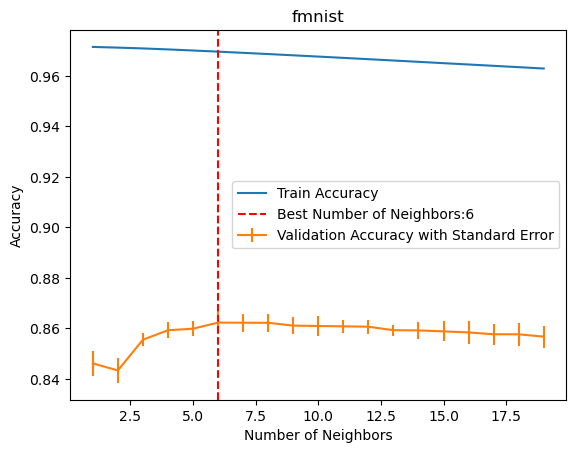

In [54]:
plt.plot(neighbor_list, train_accuracy, label = "Train Accuracy")
plt.errorbar(neighbor_list, neighbor_accuracy, yerr=std_error, label = "Validation Accuracy with Standard Error")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
# plot a dashed line at the best number of neighbors
plt.axvline(np.argmax(neighbor_accuracy)+1, color = "r", linestyle = "--",
             label = "Best Number of Neighbors:" + str(np.argmax(neighbor_accuracy)+1))
plt.title("fmnist")
plt.legend()
plt.show()

Train Accuracy:  0.8968666666666667
Test Accuracy:  0.8583


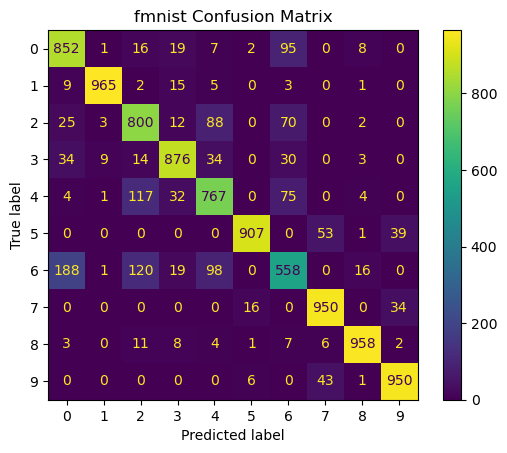

In [27]:
## now we get the actual train/test accuracy
pca = PCA(n_components=50, random_state=42)
knn = KNeighborsClassifier(n_neighbors=6, n_jobs=-1)

## transform the training and test data
expl_pca_train = pca.fit_transform(X_train)
expl_pca_test = pca.transform(X_test)

## fit the model
knn.fit(expl_pca_train, y_train.values.ravel())

## predict
predict = knn.predict(expl_pca_test)
predict_train = knn.predict(expl_pca_train)

## accuracy
test_score = np.mean(predict == y_test.values.ravel())
train_score = np.mean(predict_train == y_train.values.ravel())

print("Train Accuracy: ", train_score)
print("Test Accuracy: ", test_score)

## confusion matrix
cm = confusion_matrix(y_test, predict, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()
plt.title("fmnist Confusion Matrix")
plt.savefig("fmnist_confusion_matrix.png")